## Topological Data Analysis of Financial Time Series: Landscapes of Crashes
### By Yuri Katz
### Implemented by Harsha Somisetty

In [1]:
import yfinance as yf
from ripser import ripser, Rips
import persim 
from persim import plot_diagrams, PersistenceImager
from persim.landscapes import (
    PersLandscapeApprox,
    PersLandscapeExact,
    average_approx, 
    snap_pl, 
    plot_landscape,
    plot_landscape_simple
)
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from tqdm import tqdm
import numpy as np
from numpy import linalg as LA
import pandas as pd
from datetime import datetime, timedelta, date



In [2]:
#downloading data
#gspc is spy, ixic is qqq, dji is dow, rut is russel
data = yf.download("^GSPC ^DJI ^IXIC ^RUT", start="1992-01-01", end="2016-12-08", interval = "1d", group_by = "ticker")
data_df = np.log(data.xs("Adj Close", level=1, axis=1).pct_change()+1)[1:]
# price_data = data_df[["^GSPC", "^DJI", "^IXIC", "^RUT"]]
def dates_to_index(dates):
    return [len(data_df[:date])-1 for date in dates]

wins = [50, 100]

[*********************100%***********************]  4 of 4 completed


3it [00:00, 63.66it/s]


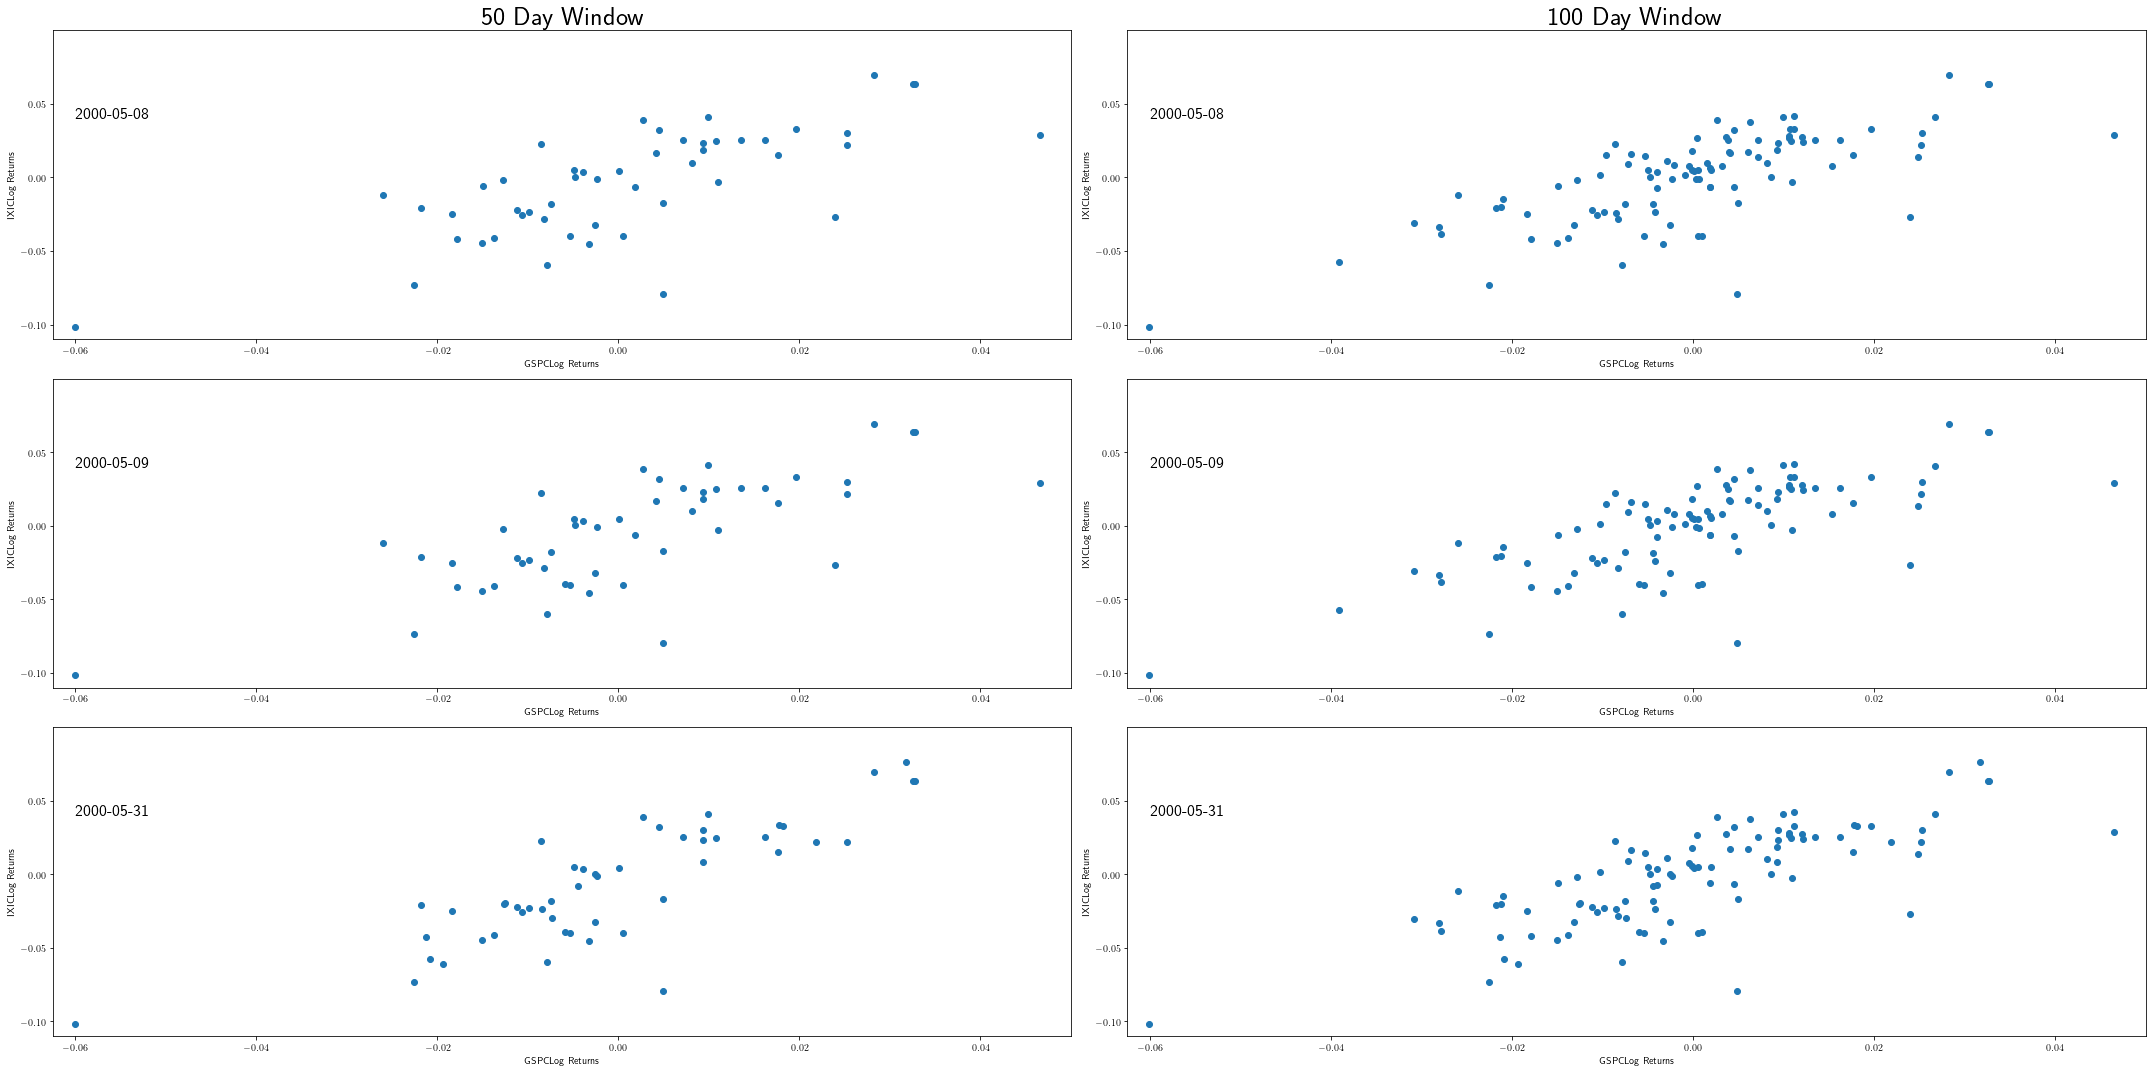

In [3]:
#example point clouds



# The paper calulates point clouds from the data of the next 50 trading days from the labeled day. 
# We calc point clouds by using previous 50 day historical data, not taking into account trading days

#get only specific dates, these match days in paper
dates = ["2000-5-08", "2000-5-09", "2000-5-31"]



# this commented code generates all clouds for a specific month, change index in month function to choose a month
# def daterange(date1, date2):
#     for n in range(int ((date2 - date1).days)+1):
#         yield date1 + timedelta(n)

# def month(mon): return date(2000,mon,1), date(2000, mon+1, 1)
# start_dt, end_dt = month(4)
# dates = [dt.strftime("%Y-%m-%d") for dt in daterange(start_dt, end_dt) if dt.isoweekday() not in [6,7]]



#Converts all dates to indexes in dataframe
dates = dates_to_index(dates)


fig, axs = plt.subplots(len(dates), 2, figsize=(30, 15))
cats = ["^GSPC", "^IXIC"]

# plot cloud for each date, left column is window size 50, right is window size 100
for ind, date in tqdm(enumerate(dates)):
    for j in range(2):
        # Figure 7 in paper plotted clouds by using data starting from the date printed. This implementation plots data ending at the date given, so modify as needed
        axs[ind, j].scatter(x = data_df[date-wins[j]:date][cats[0]], y = data_df[date-wins[j]:date][cats[1]])

        # set various window sizes and axis, this matches the specs in paper
        axs[ind, j].set_ylim([-.11, .1])
        axs[ind, j].set_xlim([-.0625, .05])
        axs[ind, j].xaxis.set_ticks(np.arange(-.06, .06, .02))
        axs[ind, j].yaxis.set_ticks(np.arange(-.1, .1, .05))
        axs[ind, j].text(-.06, .04, data_df.iloc[date].name.strftime('%Y-%m-%d'), fontsize=17)
        axs[ind, j].set_xlabel(cats[0][1:] + "Log Returns")
        axs[ind, j].set_ylabel(cats[1][1:] + "Log Returns")

axs[0, 0].set_title(str(wins[0]) + " Day Window", fontsize=26)
axs[0, 1].set_title(str(wins[1]) + " Day Window", fontsize=26)

plt.tight_layout()
plt.show()

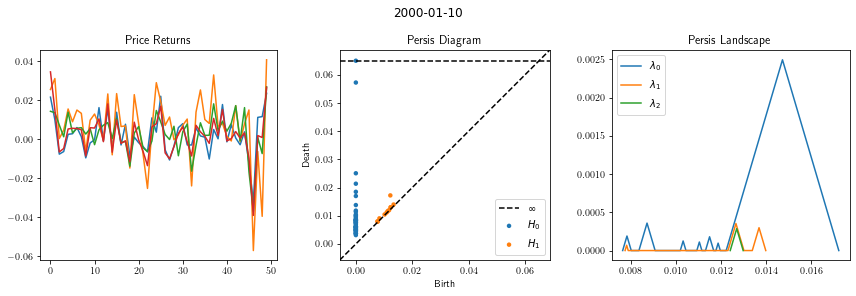

In [4]:
# Plotting a window's returns, persistence diagram, and landscape, corresponds to figure 8 picture 1

dates = ["2000-01-10"]
inds = dates_to_index(dates)

# for ind in tqdm
dgms = ripser(data_df.to_numpy()[inds[0]-50:inds[0]], maxdim=1)['dgms']

fig, axs = plt.subplots(1, 3)
fig_size = 4
fig.set_size_inches(fig_size*3, fig_size)

axs[0].plot(np.arange(0, wins[0]), data_df.to_numpy()[inds[0]-50:inds[0]])
axs[0].set_title("Price Returns")
plot_diagrams(dgms, title="Persis Diagram", ax=axs[1])

persim.landscapes.plot_landscape_simple(persim.landscapes.PersLandscapeExact(dgms, hom_deg=1), title="Persis Landscape", ax=axs[2])

fig.suptitle(dates[0])
plt.tight_layout()
plt.show()

In [5]:
#calculate all cloud peris diagrams, then calculate landscape norm and store in array called norm_data
norm_data = np.zeros(len(data_df))
norm_data[:] = np.NaN
for i in tqdm(range(wins[0], len(data_df))):
    arr = data_df.to_numpy()[i-wins[0]:i]
    dgms = ripser(arr, maxdim=2)['dgms']
    norm_data[i] = PersLandscapeExact(dgms, hom_deg=1).p_norm()
# data_df["L2_Norm"] = norm_data
np.save("norm_data.npy", norm_data)

100%|██████████| 6232/6232 [01:34<00:00, 66.14it/s]


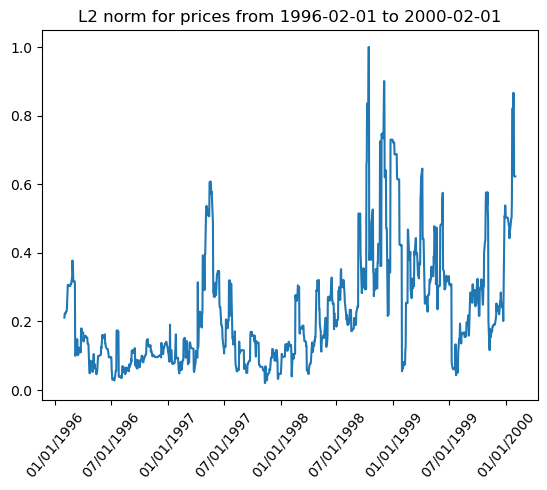

In [6]:
# #plotting l2 norm like figure 9, from certain dates
dates = ["1996-02-01", "2000-02-01"]
inds = dates_to_index(dates)

days = data_df.index[inds[0]:inds[1]]
plt.plot(days, norm_data[inds[0]:inds[1]]/np.max(norm_data[inds[0]:inds[1]]))

plt.xticks(rotation=50)
plt.title("L2 norm for prices from " + dates[0]+ " to " + dates[1])
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
# plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=100))

[*********************100%***********************]  2 of 2 completed


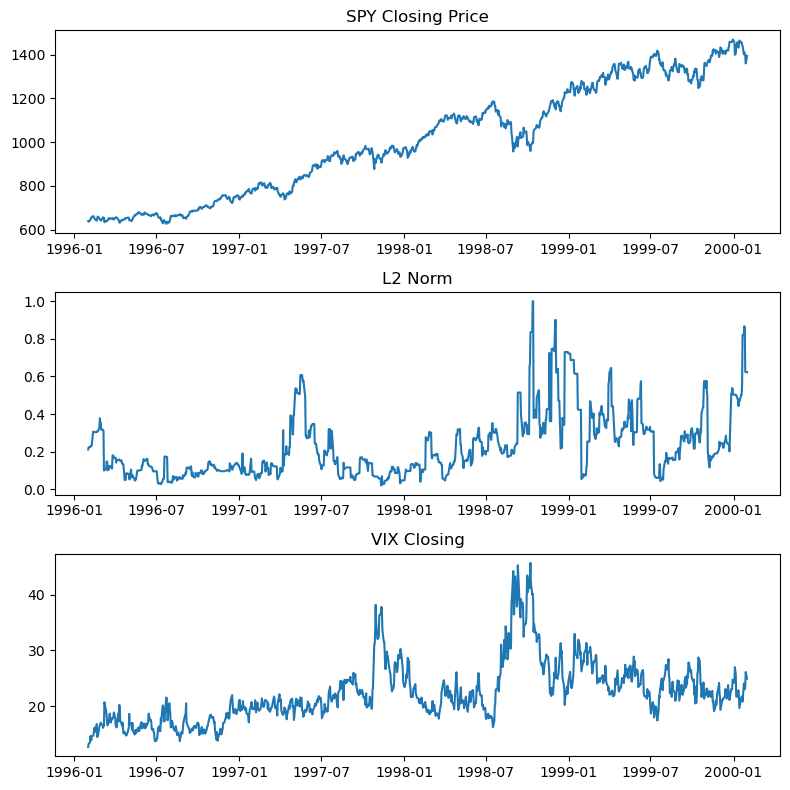

In [9]:
# Plotting spy, l2 norm, and vix price to see correlations

dates = ["1996-02-01", "2000-02-01"]
inds = dates_to_index(dates)

clean_data = yf.download("^GSPC ^VIX", start=dates[0], end=dates[1], interval = "1d", group_by = "ticker")


fig, axs = plt.subplots(3, 1)
fig_size = 8
fig.set_size_inches(fig_size, fig_size)

days = data_df.index[inds[0]:inds[1]]
axs[0].plot(days, clean_data["^GSPC"]["Close"])
axs[0].set_title("SPY Closing Price")

axs[1].plot(days, norm_data[inds[0]:inds[1]]/np.max(norm_data[inds[0]:inds[1]]))
axs[1].set_title("L2 Norm")

axs[2].plot(days, clean_data["^VIX"]["Close"])
axs[2].set_title("VIX Closing")

fig.tight_layout()